In [1]:
#import tensorflow as tf 
# https://sci-hub.se/10.1002/sim.1203
# https://journals.sagepub.com/doi/pdf/10.1177/1536867x0900900206

# Dataset

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

from utils.model import Model 

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

2025-04-24 10:32:12.734812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [3]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

# Train-test split

In [4]:
from utils.data import train_test_splitting

train_idx, test_idx = train_test_splitting(
    np.arange(data.shape[0]), test_size=0.2, stratify=data[event_col].squeeze().astype(int)
)
# Data splits
data_train, data_test = data.iloc[train_idx], data.iloc[test_idx]
print(data_train.shape, data_test.shape)

(345, 9) (87, 9)


In [5]:
duration_train = data_train[duration_col].to_numpy().squeeze()
duration_test = data_test[duration_col].to_numpy().squeeze()

event_train = data_train[event_col].to_numpy().squeeze()
event_test = data_test[event_col].to_numpy().squeeze()

In [6]:
from sksurv.util import Surv
# Create structured arrays
y_train = Surv.from_arrays(event=event_train, time=duration_train)
y_test = Surv.from_arrays(event=event_test, time=duration_test)
print(y_train.shape, y_test.shape)

(345,) (87,)


# Pre-processing

In [7]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X_train, X_test = feature_scaling(X.iloc[train_idx].values, X.iloc[test_idx].values)

In [8]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration_train, event_train, n_knots=5)
min(knots), max(knots)

(0.0, 3.9512437185814275)

# Initialize parameters

In [9]:
from utils.data import init_gamma, init_beta
#from utils.splines import spline_design_matrix
from utils.splines import bspline_design_matrix

# Create one spline equation per time point 
#D = spline_design_matrix(np.log(duration_train), knots)
D = bspline_design_matrix(np.log(duration_train), knots)

# Initialize gamma coefficients
gamma = init_gamma(D, duration_train)
#gamma = init_gamma(D, X_train, y_train)

# Initialize beta coefficients
beta = init_beta(X_train, y_train)

In [10]:
#from utils.data import init_params
#gamma, beta = init_params(data_train, duration_col, event_col, n_knots=D.shape[1])
#gamma.shape, beta.shape

In [11]:
#from utils.data import _init_gamma
#gamma = _init_gamma(D, duration_train)
#gamma.shape

# Model fitting

In [12]:
# Performance *without* training 
model = Model(epochs=1, knots=knots, learning_rate=0.01, l2_lambda=0)
model.set_params({"beta": beta, "gamma": gamma})

print(concordance_index_censored(event_train.astype(bool), duration_train, model.risk_score(X_train).squeeze()))
print(concordance_index_censored(event_test.astype(bool), duration_test, model.risk_score(X_test).squeeze()))

(0.6453319081493495, 17493, 9607, 31, 1016)
(0.614335461404527, 1058, 664, 1, 0)


(0.649202019829715, 17598, 9502, 31, 1016)
(0.5957632037144516, 1026, 696, 1, 0)


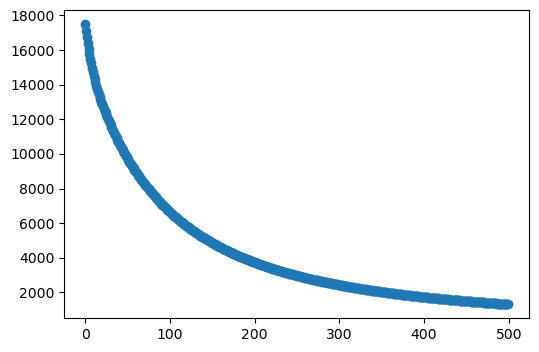

In [13]:
# Performance *with* training 
model = Model(epochs=500, knots=knots, learning_rate=0.01, l2_lambda=0)
model.set_params({"beta": beta, "gamma": gamma})
model.fit(X_train, y_train)

print(concordance_index_censored(event_train.astype(bool), duration_train, model.risk_score(X_train).squeeze()))
print(concordance_index_censored(event_test.astype(bool), duration_test, model.risk_score(X_test).squeeze()))

plt.figure(figsize=(6, 4))
plt.plot(model.losses, marker="o")

# Estimates 

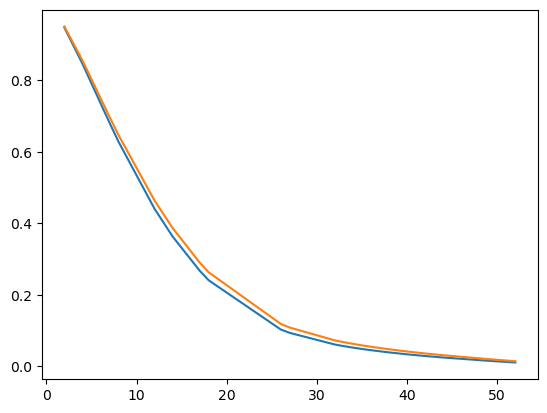

In [14]:
# NOTE: The model is highly sensitive to the initialization of beta and gamma. 
# Using least-squares method for to initialize gamma yields inverted survival curves.  

S0 = model.survival_curve(X_test[0], duration_test)
S1 = model.survival_curve(X_test[1], duration_test)

plt.figure()
idx = np.argsort(duration_test)
plt.plot(duration_test[idx], S0[idx, 0])
plt.plot(duration_test[idx], S1[idx, 0])